### for input of this notebook I used iss package to generate noisy reads (from Novaseq technology) for each genomes and Store that in Fastq file.then I get sample from each of thiese fasq file with this ratio:

In [51]:
import pickle
with open('../sampleFastqFile/dist.pickle', 'rb') as handle:
    b = pickle.load(handle)
raw = sum(b.values())
factor = 1/raw
realAbundaniesOfFile = {key:value*factor for key,value in b.iteritems()}
for i in sorted (realAbundaniesOfFile) : 
    print ((i, realAbundaniesOfFile[i])) 

('1198114', 0.006191332135010984)
('1592106', 0.030956660675054922)
('1855912', 0.17954863191531856)
('204669', 0.03435190732973836)
('2211140', 0.24246055522268822)
('234267', 0.1487916916317156)
('240015', 0.07629318953465149)
('401053', 0.07070101857399641)
('682795', 0.09366886359097264)
('926566', 0.06031555821849411)
('981222', 0.0567205911723587)


### now the goal is using the index file and fastq file we reach this ratio and evaluate our tool
## importing libraries:

In [52]:
import glob
from ete3 import NCBITaxa
import ete3.treeview
import random
import mmh3
import h5py
import numpy as np
import operator
import sys
from collections import Counter
import matplotlib.pyplot as plt
import time

these functions explained in last notebook. we use the to compute hash,minimizer and other things that we need in this notebook

In [53]:
def getHashedMinimizer(minimizer):
    return mmh3.hash(minimizer,seed=2,signed=True)
def getHashedKmer(kmer):
    return mmh3.hash(kmer,seed=1,signed=True)
def getMinimizer(seq,const):
    rev=seq[::-1]
    rev=rev.replace("A","X")
    rev=rev.replace("T","A")
    rev=rev.replace("X","T")
    rev=rev.replace("C","X")
    rev=rev.replace("G","C")
    rev=rev.replace("X","G")
    Kmer=len(seq)
    M= (Kmer/5) +1
    L=len(seq)
    min=int(''.join(["{}".format(random.randint(9, 9)) for num in range(0, M)]))
    for j in range(0, Kmer-M+1):
        if j == 0:
            sub2=seq[j:j+M]
            if getNum(sub2,const) < min:
                min=sub2
            sub2=rev[j:j+M]
            if getNum(sub2,const) < min:
                min=sub2
        else:
            sub2=seq[j:j+M]
            if getNum(sub2,const) < getNum(min,const):
                min=sub2
            sub2=rev[j:j+M]
            if getNum(sub2,const) < getNum(min,const):
                min=sub2
    return min
def getNum(st,const):
    conv = {"A":1,"C":2,"G":3,"T":4}
    temp = 0
    l = len(st)
    for i in range(len(st)):
        temp+=conv[st[i]]*(10**(l-i-1))
    return int((temp ^ const%(10**(len(st)))))

def updateMinimizer(seq,oldseq,minimizer,const):
    revseq=seq[::-1]
    revseq=revseq.replace("A","X")
    revseq=revseq.replace("T","A")
    revseq=revseq.replace("X","T")
    revseq=revseq.replace("C","X")
    revseq=revseq.replace("G","C")
    revseq=revseq.replace("X","G")
    Kmer=len(seq)
    M= (Kmer/5) +1
    firstMinimizerOfOld = oldseq[0:M]
    revseqOld=firstMinimizerOfOld[::-1]
    revseqOld=revseqOld.replace("A","X")
    revseqOld=revseqOld.replace("T","A")
    revseqOld=revseqOld.replace("X","T")
    revseqOld=revseqOld.replace("C","X")
    revseqOld=revseqOld.replace("G","C")
    revseqOld=revseqOld.replace("X","G")
    L=len(seq)
    end_f = seq[L-M:L]
    start_f = seq[0:M]
    end_r = revseq[L-M:L]
    start_r = revseq[0:M]
    minNum = getNum(minimizer,const)    
    if (getNum(revseqOld,const) == minNum) or (getNum(firstMinimizerOfOld,const) == minNum):
        if(getMinimizer(seq,const) == minNum):
            return False,minimizer
        else:
            return True,getMinimizer(seq,const)
    flag = False
    if (getNum(end_f,const) < minNum):
        minimizer = end_f
    if(getNum(start_r,const) < minNum):
        flag = True
        minimizer = start_r
    return flag,minimizer

def getLCA(listOfTaxids,tree):
    if len(listOfTaxids)==1:
        return listOfTaxids[0]
    else:
        return int(tree.get_common_ancestor(listOfTaxids).name)

random.seed(1)
n = 31
const = int(''.join(["{}".format(random.randint(0, 9)) for num in range(0, n)]))

## the tree of these 11 genomes is look like this:

In [54]:
fileNames = (glob.glob("../genomes/*.fq"))
ncbi = NCBITaxa()
ParentNode="Acidobacteria" #inja ro bayad karbar bde az kojaye derakht b paeen mikhad
ParentTaxid = ncbi.get_name_translator([ParentNode])[ParentNode][0]
tree = ncbi.get_descendant_taxa(ParentNode, return_tree=True)
taxids =[]
for PathFilename in fileNames:
    taxid = int(PathFilename.split("_")[0].split("/")[2])
    taxids.append(taxid)
tree =ncbi.get_topology(taxids)
print tree.get_ascii(attributes=["name"])


                       /-1592106
                      |
                 /392733-401053
                |     |
                |      \-926566
                |
                |      /-1198114
                |-940557
           /204434     \-682795
          |     |
          |     |--2211140
          |     |
     /204432    |--240015
    |     |     |
    |     |      \-204669
    |     |
-57723     \-234267
    |
    |--981222
    |
     \-1855912


### for each read we should find it's kmers and for each kmer we should find minimizers then we look at index file and find the taxid related to that kmer. then in above tree we adding score of that node by one
for example if for 1 kmer the taxid in index file become 204432 we do this using these functions:

In [55]:
def findNodeWithTaxid(taxid,tree):
    return tree.search_nodes(name=str(taxid))[0]

def getValueOfNode(Node):
    try:
        if Node.value > -1:
            return Node.value
    except AttributeError:
        return 0

def updateValueOfNode(tree,taxid):
    Node = findNodeWithTaxid(taxid,tree)
    try:
        Node.value += 1
    except AttributeError:
        Node.value = 1
def findRTLs(tree):
    RTLpoints = {}
    for node in tree.traverse("preorder"):
        if node.is_leaf():
            node.s = node.up.s+getValueOfNode(node)
            RTLpoints[node.name] = node.s
        elif node.is_root():
            node.s = getValueOfNode(node)
        else:
            node.s = node.up.s+getValueOfNode(node)
    maxValue = max(RTLpoints.items(), key=lambda x: x[1])[1]
    if maxValue == 0:
        return None
    else:
        candids = [key for key in RTLpoints.keys() if RTLpoints[key]==maxValue]
        return getLCA(candids,tree)

In [56]:
updateValueOfNode(tree,204432)
print tree.get_ascii(attributes=["name","value"])


                          /-1592106
                         |
                    /392733-401053
                   |     |
                   |      \-926566
                   |
                   |      /-1198114
                   |-940557
              /204434     \-682795
             |     |
             |     |--2211140
             |     |
     /204432, 1    |--240015
    |        |     |
    |        |      \-204669
    |        |
-57723        \-234267
    |
    |--981222
    |
     \-1855912


the most important function in this notebook is this function.
given the read into this function it give score to each node of tree for each kmer then after all score alignment it iterate preorder the tree and find each RTl for each leafs. then it return LCA of all the max values among that list

In [57]:
def GetNodeOfreads(read,tree):
    count = 0
    oldkmer = ""
    oldMinimizer = ""
    error = 0
    for i in range(len(read)-31+1):
        kmer = read[i:i+31]
        if count == 0:
            minimizer = getMinimizer(kmer,const)
            oldkmer = kmer
            oldMinimizer = minimizer
            Hmin = getHashedMinimizer(minimizer)
            Hkmer = getHashedKmer(kmer)
            try:
                with h5py.File("../resources/index.hdf5", "r") as f:
                    dset = f[str(Hmin)+"/list/"]
                    arr = np.array(dset)
                    dicarr = {}
                    for i in range(arr.shape[1]):
                        dicarr[arr[0,i]]=arr[1,i]
                    taxidOfKmer = dicarr[Hkmer]
                    updateValueOfNode(tree,taxidOfKmer)
            except KeyError:
                taxidOfKmer = None
                error+=1
                
        else:
            flag,minimizer = updateMinimizer(kmer,oldkmer,oldMinimizer,const)
            oldkmer = kmer
            Hmin = getHashedMinimizer(minimizer)
            Hkmer = getHashedKmer(kmer)
            try:
                if minimizer == oldMinimizer:
                    taxidOfKmer = dicarr[Hkmer]
                    updateValueOfNode(tree,taxidOfKmer)
                else:
                    with h5py.File("../resources/index.hdf5", "r") as f:
                        dset = f[str(Hmin)+"/list/"]
                        arr = np.array(dset)
                        dicarr = {}
                        for i in range(arr.shape[1]):
                            dicarr[arr[0,i]]=arr[1,i]
                        taxidOfKmer = dicarr[Hkmer]
                        updateValueOfNode(tree,taxidOfKmer)
            except KeyError:
                taxidOfKmer = None
                error +=1
            
            oldMinimizer = minimizer
        count += 1
    return findRTLs(tree)

## the main part of code
in this part we use all the above function and give each read of test case to GetNodeOfreads.
then we store all the taxids that it give us for each read in list and count all the reads that dont assign to any taxid

In [58]:
%%time
from Bio import SeqIO
count = 0
percent = 0
unKnownReads = 0
knownTaxids = []
for record in SeqIO.parse("../sampleFastqFile/test_reads.fastq", "fastq"):
    tree =ncbi.get_topology(taxids)
    taxidOfread = GetNodeOfreads(str(record.seq),tree)
    if taxidOfread == None:
        knownTaxids.append("unknown")
    else:
        knownTaxids.append(str(taxidOfread))
    if count%50 == 0:
        print str(percent)+"%"
        percent += 1
    count +=1

0%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%
100%
CPU times: user 1h 59min 29s, sys: 3min 1s, total: 2h 2min 31s
Wall time: 59min 32s


in this cell for each taxid we find number of reads that support that taxids. and then by normalization of these counts we can find the ratio of each taxid in our sample. then we can compare result to real abundancy that introduce in first cell

In [62]:
d = dict(Counter(knownTaxids))
total = sum(d.itervalues(), 0.0)
dist = {k: v / total for k, v in d.iteritems()}
for key,val in dist.iteritems():
    if key == "unknown":
        print str(dist[key]*100)+"% of reads was from unknown organism in this tree"
    else:
        print str(dist[key]*100)+"% of reads was from "+str(ncbi.get_taxid_translator([int(key)])[int(key)])+" with taxid : "+key

24.2460555223% of reads was from Acidisarcina polymorpha with taxid : 2211140
6.03155582185% of reads was from Terriglobus roseus DSM 18391 with taxid : 926566
9.3668863591% of reads was from Granulicella mallensis MP5ACTX8 with taxid : 682795
7.62931895347% of reads was from Acidobacterium capsulatum ATCC 51196 with taxid : 240015
3.09566606751% of reads was from Terriglobus albidus with taxid : 1592106
14.8791691632% of reads was from Candidatus Solibacter usitatus Ellin6076 with taxid : 234267
17.9548631915% of reads was from Luteitalea pratensis with taxid : 1855912
3.43519073297% of reads was from Candidatus Koribacter versatilis Ellin345 with taxid : 204669
0.619133213501% of reads was from Granulicella tundricola MP5ACTX9 with taxid : 1198114
5.67205911724% of reads was from Chloracidobacterium thermophilum B with taxid : 981222
7.0701018574% of reads was from Terriglobus saanensis SP1PR4 with taxid : 401053


the bar plot of our estimation

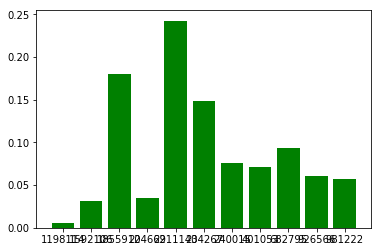

In [63]:
keys = []
vals = []
for i in sorted (dist) : 
    keys.append(i)
    vals.append(dist[i])
plt.bar(keys,vals, color='g')
plt.show()

the bar plot of real ratio

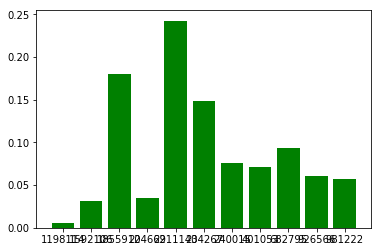

In [64]:
keys = []
vals = []
for i in sorted (realAbundaniesOfFile) : 
    keys.append(i)
    vals.append(realAbundaniesOfFile[i])
plt.bar(keys,vals, color='g')
plt.show()

as you can see there is exactly the same. because I simulate reads from all genomes in my tree. if I use for example human reads this two bar plot make differ